In [58]:
import numpy as np
import torch
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

import torchvision.transforms as transforms


from bgan.datasets import make_semi_dataset_from_tensors, make_batch_generator, DatasetFromTensors
from bgan.synth_utils import js_div, kl_div, pca
from bgan.priors import FactorizedNormalPrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                        download=True, transform=transform)
x_train, y_train = trainset.train_data.float() / 255, trainset.train_labels
x_test, y_test = testset.test_data.float() / 255, testset.test_labels
x_test = x_test[:, None, :, :].float()
y_test = y_test.numpy()

labeled, unlabeled = make_semi_dataset_from_tensors(x_train[:, None, :, :].float(), 
                                                    y_train[:, None], labeled_fraction=0.1)
fulltrain = DatasetFromTensors(x_train[:, None, :, :].float(), y_train[:, None], labeled=True)
# labeledloader = torch.utils.data.DataLoader(labeled, batch_size=50,
#                                           shuffle=True, num_workers=2)

In [101]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)
    
class Network(nn.Module):
    
    def __init__(self, d=128, K=11):
        super(Network, self).__init__()
        self.K = K
        self.init_net(d)
    
    # initializers
    def init_net(self, d):
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
#         self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)
        self.fc1 = nn.Linear(576, 100)
        self.fc1_drop = nn.Dropout()
        self.fc2 = nn.Linear(100, self.K)

    # forward method
    def forward(self, input):
        x = F.relu(self.conv1(input))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = x.view(-1, 576)
        x = self.fc1_drop(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def partial_forward(self, input):
        x = F.relu(self.conv1(input))
        x = F.relu(self.conv2_bn(self.conv2(x)))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = x.view(-1, 576)
        x = F.relu(self.fc1(x))
#         x = self.fc2(x)
        return x

    def residual_forward(self, input):
        x = self.fc2(input)
        return x

In [102]:
class SemiClassifier():
    
    def __init__(self, net, lr=0.01):#, unlabeled_ds=None, semi=True, labeled_ds, ):
        self.net = net
        self._init_optimizer(lr)
    
    def loss(self, x_l, y_l, x_u=None):
        
        d_l = self.net.forward(x_l)
            
        ce = nn.CrossEntropyLoss()
        l_loss = ce(d_l, y_l)
        loss = l_loss
        if x_u is not None:
            d_u = self.net.forward(x_u)
#             max_probs = torch.max(torch.log(d_u), 1)[0]
#             u_loss = torch.mean(-max_probs) / 10
#             loss += u_loss
            loss += -torch.sum(d_u * torch.log(d_u)) / 10
        
        return loss
        
    
    def _init_optimizer(self, lr):
        self.optimizer = optim.Adam(self.net.parameters(),
                lr=lr, betas=(0.5, 0.999))
        
    def step(self, x_l, y_l, x_u=None):
        
        self.net.zero_grad()
        loss = self.loss(x_l, y_l, x_u)   
        loss.backward()
        self.optimizer.step()
        return loss.cpu().data.numpy()
        
    def predict(self, x):
        return self.net.forward(x)
    
    
# class GANBasedClassifier():
    
#     def __init__(self, net, lr=0.01):#, unlabeled_ds=None, semi=True, labeled_ds, ):
#         self.net = net
#         self._init_optimizer(lr)
    
#     def loss(self, x_l, y_l, x_u=None, z=None):
        
#         d_l = self.net.forward(x_l)
            
#         ce = nn.NLLLoss()
#         l_loss = ce(d_l, y_l)
#         loss = l_loss
#         if x_u is not None:
#             d_u = self.net.forward(x_u)
#             probs = F.softmax(d_u)
#             sum_probs = torch.sum(probs, 1)[:-1] # Right?
#             u_loss = -torch.mean(torch.log(sum_probs))
#             loss += u_loss
# #             loss += -torch.sum(d_u * torch.log(d_u)) / 10

#         if z is not None:
#             d_z = self.net.forward(z)
# #             d_z = self.net.forward_last_layers(z)
#             z_vals = torch.ones(z.size()[0]) * (self.net.K-1)
#             z_vals = Variable(z_vals, requires_grad=False).long()
#             z_loss = ce(d_z, z_vals)
#             loss += z_loss
        
#         return loss
        
    
#     def _init_optimizer(self, lr):
#         self.optimizer = optim.Adam(self.net.parameters(),
#                 lr=lr, betas=(0.5, 0.999))
        
#     def step(self, x_l, y_l, x_u=None, z=None):
        
#         self.net.zero_grad()
#         loss = self.loss(x_l, y_l, x_u, z)   
#         loss.backward()
#         self.optimizer.step()
#         return loss.data.numpy()
        
#     def predict(self, x):
#         return F.softmax(self.net.forward(x))

class GANBasedClassifier():
    
    def __init__(self, net, lr=0.01):#, unlabeled_ds=None, semi=True, labeled_ds, ):
        self.net = net
        self._init_optimizer(lr)
    
    def loss(self, x_l, y_l, x_u=None, z=None):
        
        stability_fix = 1e-8
        d_l = self.net.forward(x_l)
            
        ce = nn.CrossEntropyLoss()
        l_loss = ce(d_l, y_l)
        loss = l_loss
        if x_u is not None:
            d_u = self.net.forward(x_u)
            probs_u = F.softmax(d_u)
            sum_probs = torch.sum(probs_u, 1)[:-1] # Right?
            u_loss = -torch.mean(torch.log(sum_probs + stability_fix))
            loss += u_loss
            loss += -torch.mean(torch.sum(probs_u * torch.log(probs_u + stability_fix), 1))
            

        if z is not None:
            d_z = self.net.residual_forward(z)
#             d_z = self.softmax(dz)
            z_vals = torch.ones(z.size()[0]) * (self.net.K-1)
            z_vals = Variable(z_vals, requires_grad=False).long().cuda()
            z_loss = ce(d_z, z_vals) / 3
            loss += z_loss
#         print(loss)
        
        return loss
        
    
    def _init_optimizer(self, lr):
        self.optimizer = optim.Adam(self.net.parameters(),
                lr=lr, betas=(0.5, 0.999))
        
    def step(self, x_l, y_l, x_u=None, z=None):
        
        self.net.zero_grad()
        loss = self.loss(x_l, y_l, x_u, z)   
        loss.backward()
        self.optimizer.step()
        return loss.cpu().data.numpy()
        
    def predict(self, x):
        d = self.net.forward(x)
        return F.softmax(d)
    
    
    
def make_z_gen(batch_size):
    while True:
        z = 2 * (np.random.rand(batch_size, 50))#.reshape([batch_size, 1, 28, 28])
        z = torch.from_numpy(z).float()
        yield Variable(z, requires_grad=False)
        
def make_z_gen_from_unlabeled(batch_size, dataset):
    ds_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
            shuffle=True, num_workers=2)
    while True:
        for batch in ds_loader:
#             z = .2 * (np.random.rand(batch.size()[0], 784) - 0.5).reshape([batch.size()[0], 1, 28, 28])
#             z = torch.from_numpy(z).float()
#             z = Variable(z, requires_grad=False)

#             x = np.flip(batch.numpy(), axis=2).copy()
#             x = torch.from_numpy(x).float()
#             x = batch.permute(0, 1, 3, 2)
#             x = Variable(x, requires_grad=False)
            x = Variable(batch)
            x = x.cuda()
            x = net.partial_forward(x) # NOTE: hope it works
            x = x.cpu().data
            x = x.numpy()
            x = (x + x[::-1])/2
#             x = x + z
            x = Variable(torch.from_numpy(x), requires_grad=False).float()
    
#             x[x > 1.] = 1.
#             x[x < 0.] = 0.
            yield x

## GAN-like

In [103]:
net = Network(d=16, K=11)
net.apply(weights_init)
model_gan = GANBasedClassifier(net, lr=5e-4)
net.cuda()

Network (
  (conv1): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear (576 -> 100)
  (fc1_drop): Dropout (p = 0.5)
  (fc2): Linear (100 -> 11)
)

In [104]:
labeled_gen = make_batch_generator(labeled, 50)
# labeled_gen = make_batch_generator(fulltrain, 50)
unlabeled_gen = make_batch_generator(unlabeled, 50)
# z_gen = make_z_gen(50)
z_gen = make_z_gen_from_unlabeled(50, unlabeled)

In [106]:
mean_loss = 0
t = 0

for i in range(20000):
    x_l, y_l = next(labeled_gen)
    x_u = next(unlabeled_gen)
    z = next(z_gen)
    
    if not ((i+1) % 100):
        print(i+1, mean_loss/t)
        mean_loss = 0
        t = 0
        
    if not((i+1) % 500):
        model_gan.net.eval()
        preds_prob = model_gan.predict(Variable(x_test.cuda())).cpu().data.numpy()[:, :-1]
        preds_class = np.argmax(preds_prob, axis=1)
        print('\tAccuracy:', np.sum(y_test == preds_class) / y_test.shape[0])
        model_gan.net.train()
    loss = model_gan.step(x_l.cuda(), y_l.cuda(), x_u.cuda(), z.cuda())
#     loss = model_gan.step(x_l.cuda(), y_l.cuda(), x_u=None, z=z.cuda())
    mean_loss += loss
    t += 1


100 [ 0.27475867]
200 [ 0.25930208]
300 [ 0.26467666]
400 [ 0.29562709]
500 [ 0.26826969]
	Accuracy: 0.98
600 [ 0.24599138]
700 [ 0.23193052]
800 [ 0.25556731]
900 [ 0.26379505]
1000 [ 0.28831175]
	Accuracy: 0.9803
1100 [ 0.29433241]
1200 [ 0.25152108]
1300 [ 0.25691316]
1400 [ 0.25938508]
1500 [ 0.26892498]
	Accuracy: 0.9777
1600 [ 0.27270707]
1700 [ 0.26437685]
1800 [ 0.26051778]
1900 [ 0.27279007]
2000 [ 0.27797136]
	Accuracy: 0.9782
2100 [ 0.2710661]
2200 [ 0.26410463]
2300 [ 0.25054395]
2400 [ 0.27450237]
2500 [ 0.25663432]
	Accuracy: 0.978
2600 [ 0.27406663]
2700 [ 0.26792753]
2800 [ 0.24033946]
2900 [ 0.2686041]
3000 [ 0.27621326]
	Accuracy: 0.9805
3100 [ 0.25860459]
3200 [ 0.26378515]
3300 [ 0.26235777]
3400 [ 0.26371619]
3500 [ 0.29881147]
	Accuracy: 0.9776
3600 [ 0.24804606]
3700 [ 0.25177759]
3800 [ 0.25145566]
3900 [ 0.25706971]
4000 [ 0.23883204]
	Accuracy: 0.9809
4100 [ 0.25218469]
4200 [ 0.2492798]
4300 [ 0.25835899]
4400 [ 0.27938417]
4500 [ 0.26806134]
	Accuracy: 0.979

In [30]:
z = next(z_gen)

FileNotFoundError: [Errno 2] No such file or directory

In [ ]:
net.residual_forward(z.cuda())

In [31]:
imgs = z.data.numpy()

In [32]:
z[:, :, ::2].size()

IndexError: trying to index 3 dimensions of a 2 dimensional tensor

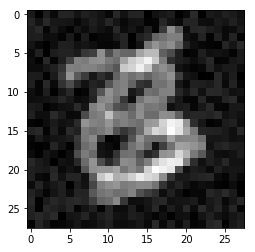

In [29]:
plt.imshow(imgs[4, 0], cmap='gray')

In [98]:
preds_class[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [99]:
y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

In [100]:
np.sum(y_test == preds_class)

980

In [101]:
preds_prob = model_gan.predict(Variable(x_test)).data.numpy()[:, :-1]
preds_class = np.argmax(preds_prob, axis=1)
print('\tAccuracy:', np.sum(y_test == preds_class) / y_test.shape[0])

	Accuracy: 0.098


## Supervised

In [84]:
net_sup = Network(d=16, K=10)
net_sup.apply(weights_init)
net_sup.cuda()
model_sup = SemiClassifier(net_sup, lr=1e-2)

In [85]:
# labeled_gen = make_batch_generator(labeled, 50)
labeled_gen = make_batch_generator(fulltrain, 50)

In [92]:
mean_loss = 0
t = 0
for i in range(5000):
    x_l, y_l = next(labeled_gen)
    if not ((i+1) % 100):
        print(i, mean_loss/t)
        mean_loss = 0
        t = 0
    if not((i+1) % 500):
        model_sup.net.eval()
        preds_prob = model_sup.predict(Variable(x_test.cuda())).cpu().data.numpy()
        preds_class = np.argmax(preds_prob, axis=1)
        print('\tAccuracy:', np.sum(y_test == preds_class) / y_test.shape[0])
        model_sup.net.train()
    loss_sup = model_sup.step(x_l.cuda(), y_l.cuda())
    mean_loss += loss_sup
    t += 1

99 [ 0.05586711]
199 [ 0.04455144]
299 [ 0.05402912]
399 [ 0.05330829]
499 [ 0.0556889]
	Accuracy: 0.9851
599 [ 0.07753433]
699 [ 0.05231236]
799 [ 0.05326035]
899 [ 0.05151143]
999 [ 0.04803175]
	Accuracy: 0.9873
1099 [ 0.07432346]
1199 [ 0.04435712]
1299 [ 0.05953983]
1399 [ 0.0593127]
1499 [ 0.06042916]
	Accuracy: 0.988
1599 [ 0.04346243]
1699 [ 0.04161877]
1799 [ 0.05192462]
1899 [ 0.06214496]
1999 [ 0.05058483]
	Accuracy: 0.9904
2099 [ 0.04232484]
2199 [ 0.05907075]
2299 [ 0.05297511]
2399 [ 0.03687052]
2499 [ 0.04399872]
	Accuracy: 0.9896
2599 [ 0.04483898]
2699 [ 0.05872367]
2799 [ 0.05163767]
2899 [ 0.0281372]
2999 [ 0.03843537]
	Accuracy: 0.9874
3099 [ 0.05634604]
3199 [ 0.05108779]
3299 [ 0.05326422]
3399 [ 0.03922155]
3499 [ 0.03579673]
	Accuracy: 0.9904
3599 [ 0.06066977]
3699 [ 0.0593501]
3799 [ 0.05379179]
3899 [ 0.05061294]
3999 [ 0.04410901]
	Accuracy: 0.9893
4099 [ 0.04621612]
4199 [ 0.04991847]
4299 [ 0.04839054]
4399 [ 0.04990892]
4499 [ 0.04392475]
	Accuracy: 0.9897

In [57]:
preds_prob = model_sup.predict(Variable(x_test)).data.numpy()
preds_class = np.argmax(preds_prob, axis=1)

### Semi-supervised

In [119]:
net_semi = Network(10)
net_semi.apply(weights_init)
model_semi = SemiClassifier(net_semi, lr=1e-3)

In [120]:
labeled_gen = make_batch_generator(labeled, 50)
unlabeled_gen = make_batch_generator(unlabeled, 50)


In [29]:
# def make_random_gen(batch_size, shape=50):
#     while True:
#         z = np.random.rand(batch_size, shape)* 2 - 1
#         return Variable(z, requires_grad=False).float()

In [30]:
mean_loss = 0
t = 0
for i in range(5000):
    x_l, y_l = next(labeled_gen)
    x_u = next(unlabeled_gen)
    if not ((i+1) % 100):
        print(i+1, mean_loss/t)
        mean_loss = 0
        t = 0
    if not((i+1) % 500):
        preds_prob = model_semi.predict(Variable(x_test)).data.numpy()
        preds_class = np.argmax(preds_prob, axis=1)
        print('\tAccuracy:', np.sum(y_test == preds_class) / y_test.shape[0])
    loss = model_semi.step(x_l, y_l, x_u)
    mean_loss += loss
    t += 1

100 [ 1.69764185]
200 [ 1.15048254]
300 [ 1.04159737]
400 [ 1.01232195]
500 [ 0.91960853]
	Accuracy: 0.9171
600 [ 0.81323296]
700 [ 0.8691057]
800 [ 0.81949717]
900 [ 0.80083632]
1000 [ 0.79485357]
	Accuracy: 0.9313
1100 [ 0.77135831]
1200 [ 0.7276867]
1300 [ 0.7102173]
1400 [ 0.71404135]
1500 [ 0.68416327]
	Accuracy: 0.9233
1600 [ 0.7508902]
1700 [ 0.73940122]
1800 [ 0.7443341]
1900 [ 0.72703522]
2000 [ 0.68475431]
	Accuracy: 0.933
2100 [ 0.65783495]
2200 [ 0.74128538]
2300 [ 0.74749136]
2400 [ 0.7388925]
2500 [ 0.71143442]
	Accuracy: 0.9358
2600 [ 0.68153191]
2700 [ 0.69175285]
2800 [ 0.68161893]
2900 [ 0.73074555]
3000 [ 0.644777]
	Accuracy: 0.9342
3100 [ 0.70305097]
3200 [ 0.72644961]
3300 [ 0.76000029]
3400 [ 0.64694488]
3500 [ 0.68373251]
	Accuracy: 0.938
3600 [ 0.60520154]
3700 [ 0.6878565]
3800 [ 0.71089464]
3900 [ 0.69952399]
4000 [ 0.64404511]
	Accuracy: 0.9311


Process Process-167:
Process Process-179:
Process Process-180:
Process Process-168:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions

KeyboardInterrupt: 

  File "/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
